In [1]:
import sys
sys.path.append('../code')
import FOT

import math
import numpy as np
from scipy.spatial.distance import cdist
import random
import ot

import matplotlib.pyplot as plt
import ot.plot

In [2]:
def plot_transport_heatmap(T, title="Transport plan T (rows: X_i, cols: Y_j)", 
                           xlabel = 'target index j', 
                           ylabel = 'source index i',
                           legend_label = 'mass T[i,j]'):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(T, aspect='auto')  # 행: X_i, 열: Y_j
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(legend_label)
    plt.tight_layout()
    plt.show()

# Isometry mapping

commutator norm (P*):    0.41807249621241777
commutator norm (Prev):  2.8615615049497434


Text(0.5, 1.0, 'Source and target distributions')

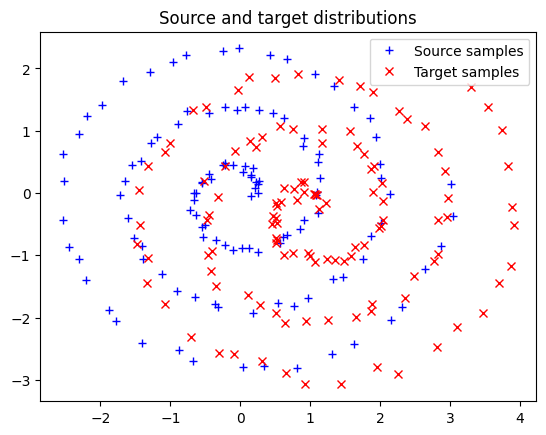

In [3]:
import numpy as np
from scipy.spatial.distance import cdist

# 1) 데이터: 불균일 스파이럴 (표본 간격 랜덤)
def spiral(t, a=0.2, b=0.15):
    r = a + b*t
    return np.stack([r*np.cos(t), r*np.sin(t)], axis=1)

rng = np.random.default_rng(0)
n = 120
t_sorted = np.linspace(0, 6*np.pi, n)
# 불균일 표본: 약간의 jitter로 순서 간격을 깨서 대칭성 제거
tX = t_sorted + rng.normal(0, 0.03, size=n)

xs = spiral(tX) + 0.05*np.random.randn(n,2)  # X points (2D)

# 2) 등거리 변환: 회전 + 평행이동
phi = 0.7
R = np.array([[np.cos(phi), -np.sin(phi)],
              [np.sin(phi),  np.cos(phi)]])
shift = np.array([1.0, -0.3])
xt = xs @ R.T + shift + 0.05*np.random.randn(n,2)  # Y = rigid transform of X

# 3) 커널: 2D 좌표 기반 RBF (distance similarity; 감소형)
def rbf_kernel(X, h=None):
    D2 = cdist(X, X, 'sqeuclidean')
    if h is None:
        # 평균 5-NN 거리의 중앙값을 스케일로
        D = np.sqrt(D2)
        k = 5
        knei = np.partition(D, k, axis=1)[:, k]
        h = np.median(knei) + 1e-8
    K = np.exp(-D2 / (h**2))
    # 정규화(선택): 대각합 스케일 차이 완화
    d = K.sum(1, keepdims=True)
    K = K / np.sqrt(d @ d.T)
    return K

KX = rbf_kernel(xs)
KY = rbf_kernel(xt)

# 4) 확인: 정답 퍼뮤만 커뮤테이터 ~0, 역순은 큼
# 정답 퍼뮤는 생성 인덱스 그대로 (P* = I)
def comm_norm(KA, KB, P):
    # || KA P - P KB ||_F
    return np.linalg.norm(KA @ P - P @ KB, 'fro')

P_star = np.eye(n)                 # 정답
P_rev  = np.fliplr(np.eye(n))      # 역순(가짜)

print("commutator norm (P*):   ", comm_norm(KX, KY, P_star))
print("commutator norm (Prev): ", comm_norm(KX, KY, P_rev))

# 5) 이제 너의 QP에서 \hat D_X^\kappa=KX, \hat D_Y^\kappa=KY, alpha=1 로 두고 FW 실행
#    -> \hat{\pi}는 단일 대각선(정답)에 질량이 모여야 함.
# model = FOT.ConvexFusedTransport(alpha=1, kappa=lambda t: np.exp(-t**2),
#                                  metric='euclidean', fw_max_iter=200, ...)
# model.fit(X=None, Y=None, FX=None, FY=None, KX=KX, KY=KY, return_hard_assignment=True)

plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples")
plt.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples")
plt.legend(loc=0)
plt.title("Source and target distributions")

In [4]:
model = FOT.ConvexFusedTransport(
    alpha=1,
    # kappa=lambda t: FOT.kappa_decreasing_exp(t,p=1),
    kappa=lambda t: FOT.kappa_decreasing_exp(t,p=1),
    metric='euclidean',
    fw_max_iter=100,
    fw_stepsize='classic',
    tol=1e-7,
    lmo_method='emd'
).fit(X=tX.reshape(-1,1),Y=tX.reshape(-1,1),FX=xs,FY=xt, return_hard_assignment=True)

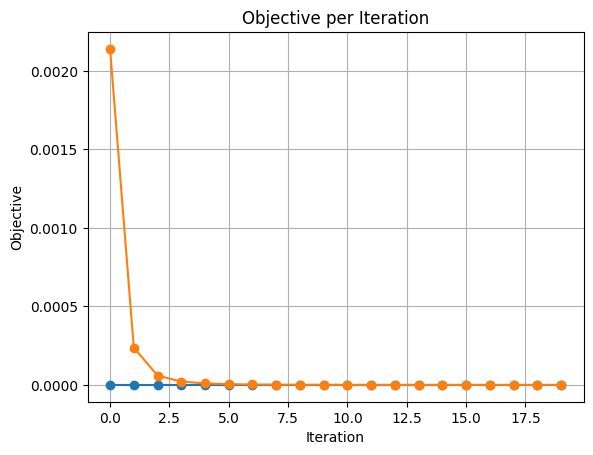

In [5]:
plt.plot(range(len(model.obj_history_)), model.obj_history_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective per Iteration')
plt.grid(True)
plt.show()

In [6]:
# plt.plot(range(len(model.gap_history_)), model.gap_history_, marker='o')
# plt.xlabel('Iteration')
# plt.ylabel('FW Gap')
# plt.title('FW Gap per Iteration')
# plt.grid(True)
# plt.show()

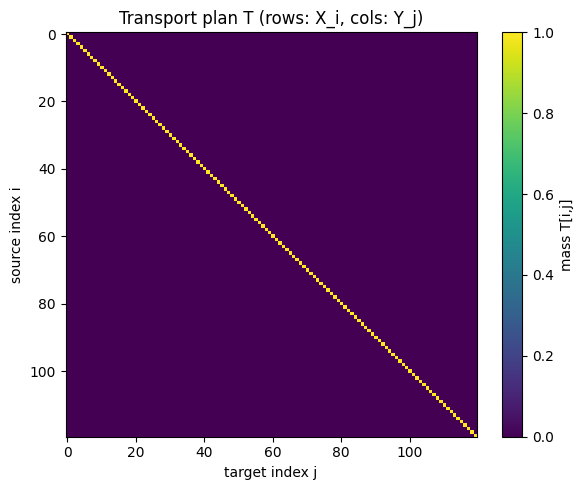

In [7]:
plot_transport_heatmap(model.P_)

In [8]:
M = ot.dist(xs,xt, metric='sqeuclidean')
C1 = ot.dist(tX.reshape(-1,1),tX.reshape(-1,1), metric='euclidean')
C2 = C1 = ot.dist(tX.reshape(-1,1),tX.reshape(-1,1), metric='euclidean')

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
alpha = 1
T_FGW = ot.gromov.fused_gromov_wasserstein(M, C1, C2, a, b, alpha=alpha, loss_fun='square_loss')

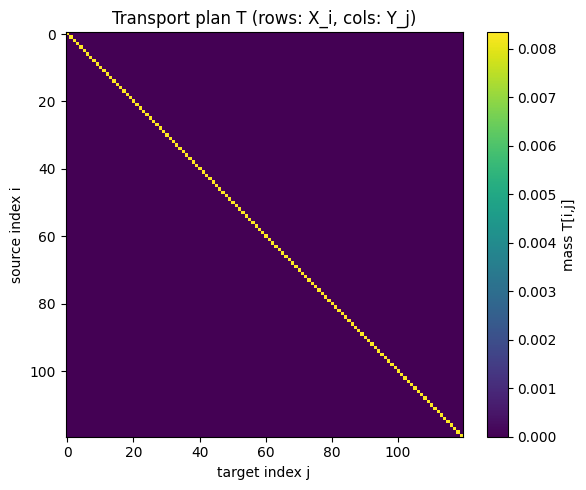

In [9]:
plot_transport_heatmap(T_FGW)

# Structured objects

In [440]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian

# -------------------------------
# Helpers: lattice wiring per block
# -------------------------------

def _grid_shape(m: int):
    """m개 노드를 r x c 격자에 최대한 정사각형에 가깝게 배치."""
    r = int(np.floor(np.sqrt(m)))
    c = int(np.ceil(m / r))
    while r * c < m:
        r += 1
    # (r-1)*c >=? keep minimal r*c >= m
    return r, c

def _wire_grid(indices, periodic=False):
    """
    indices: 이 블록의 전역 인덱스 리스트 (길이 m)
    2D 격자에 배치하고 von Neumann(4-neighbor) 연결.
    periodic=True면 토러스(모든 경계 wrap).
    """
    m = len(indices)
    if m <= 1:
        return []
    r, c = _grid_shape(m)
    # fill row-major; 마지막 셀들 비울 수 있음
    pad = r * c - m
    arr = np.array(indices + [-1] * pad).reshape(r, c)

    edges = []
    for i in range(r):
        for j in range(c):
            u = arr[i, j]
            if u < 0:  # padding
                continue
            # right neighbor
            j2 = (j + 1) % c if periodic else j + 1
            if j2 < c:
                v = arr[i, j2]
                if v >= 0:
                    edges.append((u, v))
            # down neighbor
            i2 = (i + 1) % r if periodic else i + 1
            if i2 < r:
                v = arr[i2, j]
                if v >= 0:
                    edges.append((u, v))
    return edges

def _wire_ring(indices, periodic=True):
    """
    indices: 이 블록의 전역 인덱스 리스트 (길이 m)
    1D lattice (chain or ring). periodic=True면 링, False면 체인.
    """
    m = len(indices)
    if m <= 1:
        return []
    edges = []
    for k in range(m - 1):
        edges.append((indices[k], indices[k+1]))
    if periodic and m >= 3:
        edges.append((indices[-1], indices[0]))
    return edges

# -------------------------------
# Generator: SBM with lattice inside blocks
# -------------------------------

def sample_dc_sbm(n, B, pin, pout, similar_pair=(0,1), delta=0.0, rng=None,
                  within_mode="erdos",         # "erdos" | "grid" | "ring"
                  grid_periodic=False,          # 토러스 여부 (within_mode="grid"일 때)
                  add_within_random=0.0         # 격자 위에 같은 블록 랜덤 간선 추가 확률(0~1)
                  ):
    """
    Degree-corrected SBM.
    - within_mode="erdos": 기존과 동일(블록 내 무작위)
    - within_mode="grid":  블록 내 노드를 2D 격자에 깔고 4-이웃 연결
    - within_mode="ring":  블록 내 노드를 1D 링(또는 체인)으로 연결
    - add_within_random: lattice 위에 추가로 같은 블록 내 임의 간선을 뿌릴 확률 (0이면 순수 lattice)

    Blocks 'similar_pair'는 delta≈0일수록 내부 구조가 유사.
    pin: scalar 또는 길이 B
    pout: scalar (블록 간 확률)
    """
    if rng is None: rng = np.random.default_rng()

    # balanced sizes
    sizes = [n // B] * B
    for i in range(n - sum(sizes)): sizes[i] += 1
    z = np.repeat(np.arange(B), sizes)                 # block labels (0..B-1)

    # per-block p_in
    if np.isscalar(pin): pin_b = np.array([pin]*B, dtype=float)
    else:               pin_b = np.array(pin, dtype=float)

    # enforce similarity between a,b
    a, b = similar_pair
    base = (pin_b[a] + pin_b[b]) / 2.0
    pin_b[a] = base + delta/2.0
    pin_b[b] = base - delta/2.0

    # node degree parameters (for cross-block and optional within-random edges)
    theta = rng.gamma(shape=2.0, scale=0.7, size=n)
    theta = theta / np.mean(theta)

    A = np.zeros((n, n), dtype=int)

    # ---- 1) Within-block edges: lattice or Erdos ----
    for blk in range(B):
        idx = np.where(z == blk)[0].tolist()
        if len(idx) <= 1:
            continue

        if within_mode == "grid":
            edges = _wire_grid(idx, periodic=grid_periodic)
        elif within_mode == "ring":
            edges = _wire_ring(idx, periodic=True)
        elif within_mode == "erdos":
            edges = []  # 무작위에서 아래에서 처리
        else:
            raise ValueError("within_mode must be one of {'erdos','grid','ring'}")

        # (a) lattice 간선은 deterministic하게 추가
        for u, v in edges:
            A[u, v] = A[v, u] = 1

        # (b) 같은 블록 내 랜덤 간선(옵션): lattice 위에 추가
        #     확률 = add_within_random * pin_b[blk] * theta[u]*theta[v]
        if add_within_random > 0 or within_mode == "erdos":
            # 에르되시 르니(블록 내): base는 pin_b[blk]
            basep = pin_b[blk]
            # 모든 쌍 중 이미 lattice로 연결된 건 중복 추가 방지
            for i_pos in range(len(idx)):
                u = idx[i_pos]
                for j_pos in range(i_pos+1, len(idx)):
                    v = idx[j_pos]
                    if A[u, v] == 1:
                        # 이미 연결(격자)되어 있으면 skip (원하면 중복 허용 가능하지만 여기선 0/1 그래프)
                        continue
                    pij = (add_within_random if within_mode != "erdos" else 1.0) * basep * theta[u] * theta[v]
                    if pij > 0.9: pij = 0.9
                    if rng.random() < pij:
                        A[u, v] = A[v, u] = 1

    # ---- 2) Across-block edges: DC-SBM random ----
    # 블록이 다른 모든 (i<j) 쌍에 대해 pout * theta_i * theta_j
    for i in range(n):
        for j in range(i+1, n):
            if z[i] != z[j]:
                pij = pout * theta[i] * theta[j]
                if pij > 0.9: pij = 0.9
                if rng.random() < pij:
                    A[i, j] = A[j, i] = 1

    np.fill_diagonal(A, 0)
    return A, z, theta, pin_b

def blockwise_permutation(z, block_perm=None, rng=None,
                          shuffle_within_source=True,
                          shuffle_within_target=True):
    """
    z: (n,) block labels (0..B-1)
    block_perm: dict, old_block -> new_block (예: {0:2,1:0,2:1}); None이면 identity
    shuffle_within_source: True면 소스 블록 내에서도 순서를 무작위 셔플
    shuffle_within_target: True면 타깃 블록 내 후보도 무작위 셔플
    return: perm (길이 n) so that new_order = old[perm]
    """
    if rng is None:
        rng = np.random.default_rng()

    n = len(z)
    uniq = np.unique(z)
    if block_perm is None:
        block_perm = {b: b for b in uniq}

    # (선택) 블록별 인덱스 사전
    idx_by_block = {b: np.where(z == b)[0] for b in uniq}
    if shuffle_within_source:
        for b in uniq:
            idx_by_block[b] = rng.permutation(idx_by_block[b])

    perm = np.empty(n, dtype=int)

    for b in uniq:
        src = idx_by_block[b]
        dst_block = block_perm[b]
        dst = np.where(z == dst_block)[0]
        if shuffle_within_target:
            dst = rng.permutation(dst)
        # 크기가 같다고 가정(SBM 균형 또는 완전 퍼뮤일 때)
        assert len(src) == len(dst), "block sizes must match for a pure permutation"
        perm[src] = dst
    return perm

def perm_matrix(perm):
    n = len(perm)
    P = np.zeros((n, n), dtype=float)
    P[np.arange(n), perm] = 1.0
    return P

def heat_kernel_from_adj(A, t=1.0, normalize=True, order=2):
    L = laplacian(csr_matrix(A), normed=False).toarray()
    I = np.eye(A.shape[0])
    if order == 2:
        K = I - t*L + 0.5*(t**2) * (L @ L)
    else:
        K = I - t*L
    if normalize:
        d = K.sum(1, keepdims=True); d = np.clip(d, 1e-8, None)
        K = K / np.sqrt(d @ d.T)
    return K

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

def all_pairs_geodesic(A, weighted=False):
    G = csr_matrix(A if weighted else (A > 0).astype(float))
    D = shortest_path(G, directed=False, unweighted=not weighted)
    return D

def make_block_features(z, d=6, margin=2.0, noise=0.5, rng=None):
    """Block-wise Gaussian features: f_i ~ N(mu_{z_i}, noise^2 I)."""
    if rng is None: rng = np.random.default_rng()
    B = z.max() + 1
    mu = np.zeros((B, d))
    for b in range(B): mu[b, b % d] = margin
    FX = mu[z] + noise * rng.standard_normal((len(z), d))
    return FX, mu

In [569]:
# rng = np.random.default_rng(123)
rng = None

# Graph
n = 150
B = 3
pin = 0.13
pout = 0.02
similar_pair = (0, 1)   # blocks 0 and 1 structurally similar
delta = 0.1             # == 0 → 거의 동일 구조 (hard case)
t_heat = 1            # heat-kernel scale

A_X, z, theta, pin_b = sample_dc_sbm(n, B, pin, pout, similar_pair, delta, rng, within_mode='grid')
perm = blockwise_permutation(z, block_perm={0:1,1:2,2:0}, rng=rng,
                             shuffle_within_source=True,
                             shuffle_within_target=True)
P_true = perm_matrix(perm)
A_Y = P_true.T @ A_X @ P_true

# Features (block-level informative, intra-block ambiguous)
FX, mu = make_block_features(z, d=3, margin=1, noise=1e-6, rng=rng)
FY = P_true.T @ FX
small_perturbations, mu = make_block_features(z, d=3, margin=0.0, noise=0, rng=rng)
FY = FY #+ small_perturbations

# Structure kernels
KX = heat_kernel_from_adj(A_X, t=t_heat, normalize=True, order=2)
KY = heat_kernel_from_adj(A_Y, t=t_heat, normalize=True, order=2)
# DX = all_pairs_geodesic(A_X, weighted=False)
# DY = all_pairs_geodesic(A_Y, weighted=False)
# KX = FOT.kappa_decreasing_exp(DX,p=1)
# KY = FOT.kappa_decreasing_exp(DY,p=1)

# Feature cost (squared Euclidean between features)
C_f = cdist(FX, FY, metric="sqeuclidean")

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Main plotting function
# -------------------------------
def plot_blocks_as_grids_line(
    A, z,
    gap=3.0,
    figsize=(7, 3),
    dpi=300,
    node_size=40,
    edge_width=0.6,
    edge_color="0.7",
    show_block_boxes=True,
    annotate_blocks=True,
    title="Lattice-block model (grid layout)",
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from matplotlib.collections import LineCollection

    A = np.asarray(A)
    z = np.asarray(z)
    uniq = np.unique(z)
    B = len(uniq)

    # 블록 중심 좌표 (한 줄로, 확실히 float)
    centers = [(float(b) * gap, 0.0) for b in range(B)]

    pos = np.zeros((len(z), 2), dtype=float)
    boxes = {}

    for b_idx, b in enumerate(uniq):
        idx = np.where(z == b)[0]
        m = len(idx)
        r = int(np.floor(np.sqrt(m)))
        c = int(np.ceil(m / r))
        while r * c < m:
            r += 1

        # grid을 처음부터 float로 생성
        grid = np.array([(j, -i) for i in range(r) for j in range(c)], dtype=float)[:m]
        # float 오프셋 더하기 (제자리 연산 OK)
        grid[:, 0] += centers[b_idx][0]
        grid[:, 1] += centers[b_idx][1]
        pos[idx] = grid

        x_min, y_min = grid[:, 0].min(), grid[:, 1].min()
        x_max, y_max = grid[:, 0].max(), grid[:, 1].max()
        boxes[b] = (x_min, y_min, x_max, y_max)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # 간선
    segs = []
    for i in range(len(z)):
        for j in range(i + 1, len(z)):
            if A[i, j] != 0:
                segs.append([pos[i], pos[j]])
    if segs:
        lc = LineCollection(segs, colors=edge_color, lw=edge_width, alpha=0.8)
        ax.add_collection(lc)

    # 노드
    ax.scatter(
        pos[:, 0], pos[:, 1],
        c=z, cmap="tab10",
        s=node_size, edgecolors="black", linewidths=0.4
    )

    if show_block_boxes or annotate_blocks:
        for b in uniq:
            x_min, y_min, x_max, y_max = boxes[b]
            if show_block_boxes:
                rect = Rectangle(
                    (x_min - 0.6, y_min - 0.6),
                    (x_max - x_min + 1.2), (y_max - y_min + 1.2),
                    fill=False, lw=0.8, color="black", alpha=0.5
                )
                ax.add_patch(rect)
            if annotate_blocks:
                ax.text(
                    (x_min + x_max) / 2, y_max + 1.0,
                    f"Block {b}", ha="center", va="bottom",
                    fontsize=9, fontweight="semibold"
                )

    ax.axis("equal"); ax.axis("off")
    ax.set_title(title, fontsize=10)
    fig.tight_layout()
    return fig, ax

In [570]:
model = FOT.ConvexFusedTransport(
    alpha=0.5,
    # kappa=lambda t: FOT.kappa_decreasing_exp(t,p=1),
    kappa=lambda t: t,
    metric='euclidean',
    fw_max_iter=100,
    fw_stepsize='classic',
    tol=1e-7,
    lmo_method='emd',
    pre_Cf=C_f,
    pre_DX=KX,
    pre_DY=KY
).fit(X=np.array(z).reshape(-1,1),Y=np.array(z).reshape(-1,1),FX=None,FY=None,return_hard_assignment=True)

print(np.array(model.obj_history_).mean(axis=0))

[6.60061788e-03 1.16631189e-06]


In [571]:
node_acc  = np.mean(np.argmax(model.P_, axis=1) == np.argmax(P_true, axis=1))
block_acc = np.mean(z[np.argmax(model.P_, axis=1)] == z[np.argmax(P_true, axis=1)])

print('Node Accuracy:',node_acc)
print('Block Accuracy:',block_acc)

Node Accuracy: 1.0
Block Accuracy: 1.0


In [572]:
a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
alpha = 0.5

T_FGW = ot.gromov.fused_gromov_wasserstein(C_f, KX, KY, a, b, alpha=alpha, loss_fun='square_loss')

In [573]:
node_acc  = np.mean(np.argmax(T_FGW, axis=1) == np.argmax(P_true, axis=1))
block_acc = np.mean(z[np.argmax(T_FGW, axis=1)] == z[np.argmax(P_true, axis=1)])

print('Node Accuracy:',node_acc)
print('Block Accuracy:',block_acc)

Node Accuracy: 1.0
Block Accuracy: 1.0


In [557]:
# fig, ax = plot_blocks_as_grids_line(A_Y,z,
#                                     figsize=(7,3),
#                                     dpi=500,
#                                     node_size=70,
#                                     title='',
#                                     gap=4.0)

# fig.savefig("target_lattice_blocks.png", dpi=500, bbox_inches="tight", pad_inches=0, transparent=True)

In [492]:
# fig, ax = plot_blocks_as_grids_line(A_X,z,
#                                     figsize=(7,3),
#                                     dpi=500,
#                                     node_size=70,
#                                     title='',
#                                     gap=4.0)

# fig.savefig("source_lattice_blocks.png", dpi=500, bbox_inches="tight", pad_inches=0, transparent=True)

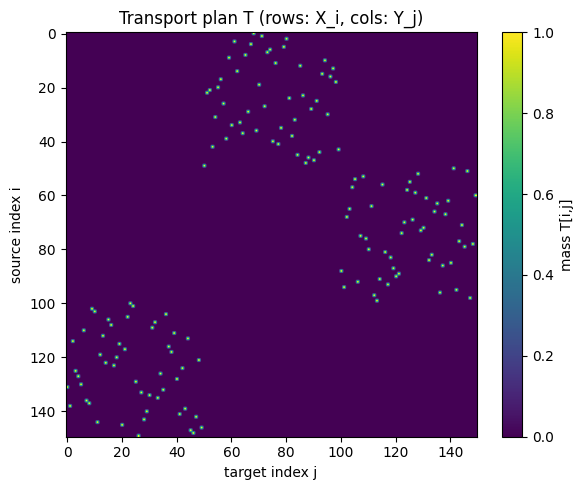

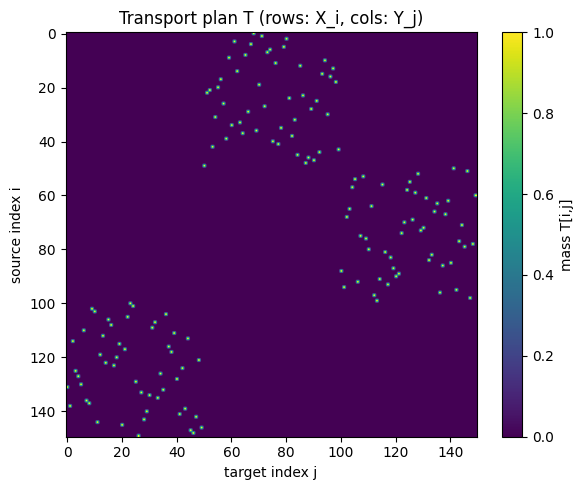

In [482]:
plot_transport_heatmap(P_true)
plot_transport_heatmap(model.P_)

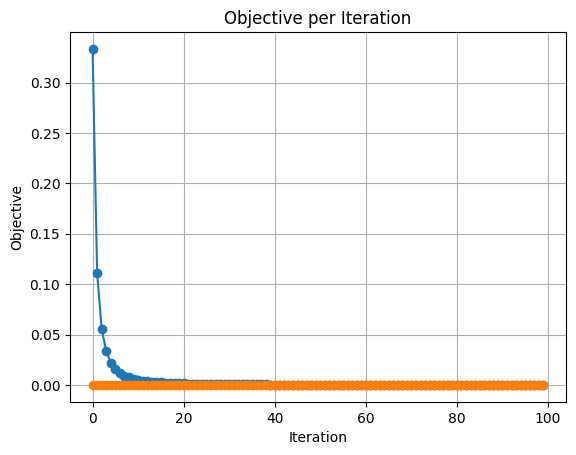

In [483]:
plt.plot(range(len(model.obj_history_)), model.obj_history_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective per Iteration')
plt.grid(True)
plt.show()

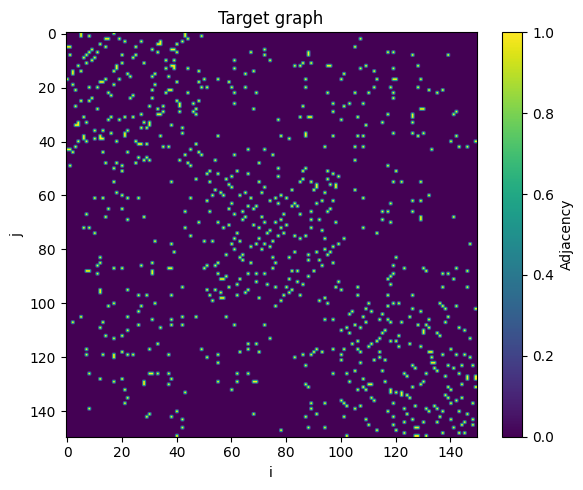

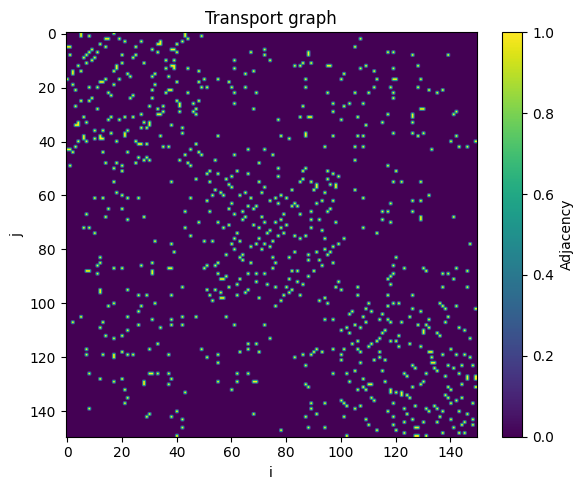

In [484]:
plot_transport_heatmap(A_Y,
                      title = 'Target graph',
                      xlabel = 'i',
                      ylabel = 'j',
                      legend_label = 'Adjacency')

plot_transport_heatmap(model.P_.T @ A_X @ model.P_,
                      title = 'Transport graph',
                      xlabel = 'i',
                      ylabel = 'j',
                      legend_label = 'Adjacency')

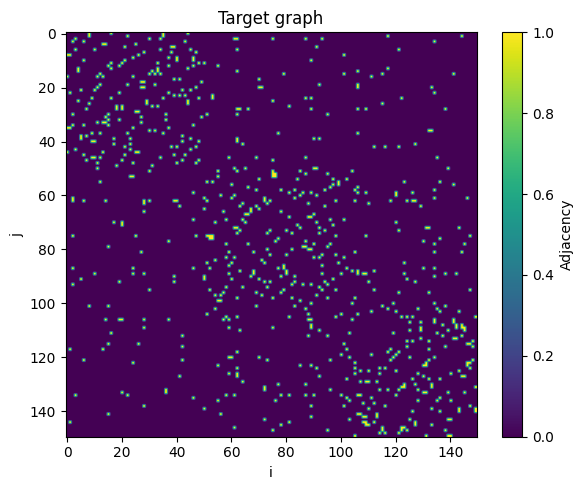

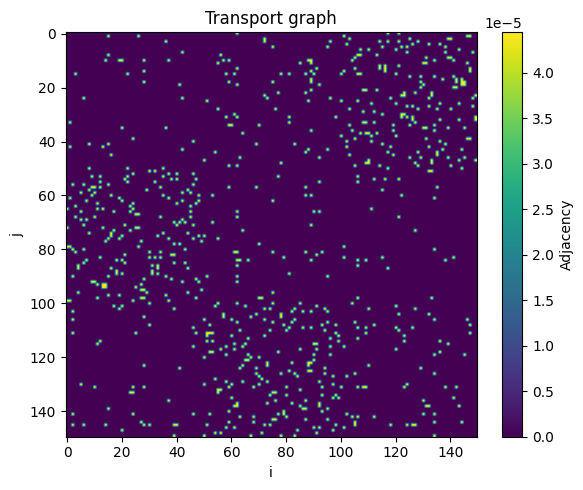

In [475]:
plot_transport_heatmap(A_Y,
                      title = 'Target graph',
                      xlabel = 'i',
                      ylabel = 'j',
                      legend_label = 'Adjacency')

plot_transport_heatmap(T_FGW @ A_X @ T_FGW,
                      title = 'Transport graph',
                      xlabel = 'i',
                      ylabel = 'j',
                      legend_label = 'Adjacency')

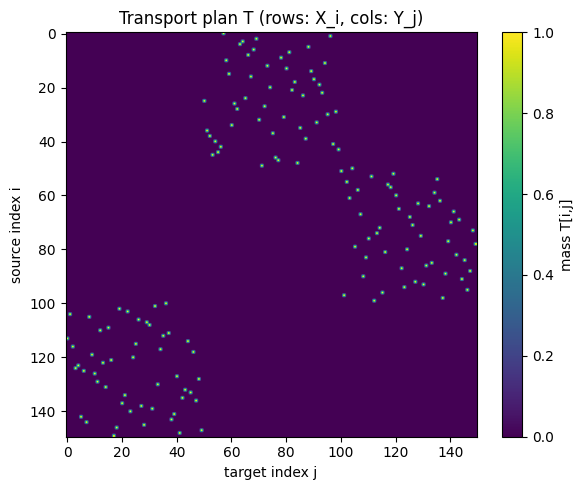

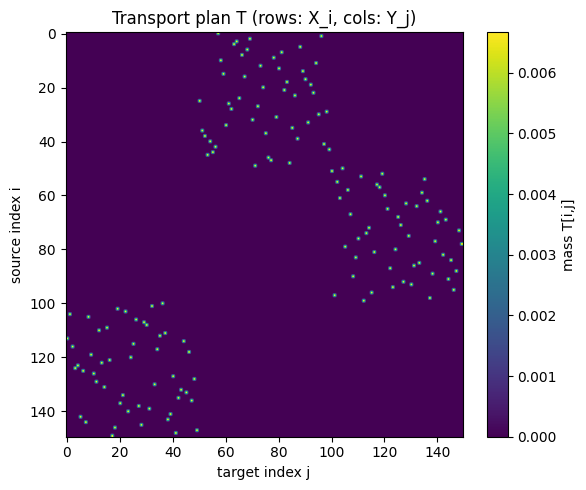

In [476]:
plot_transport_heatmap(P_true)
plot_transport_heatmap(T_FGW)